# QAOA with `qujax`

In this notebook, we will consider QAOA on an Ising Hamiltonian. In particular, we will demonstrate how to encode a circuit with parameters that control multiple gates.

In [1]:
from jax import numpy as jnp, random, value_and_grad, jit
import matplotlib.pyplot as plt

import qujax

# QAOA

The Quantum Approximate Optimization Algorithm (QAOA), first introduced by [Farhi et al.](https://arxiv.org/pdf/1411.4028.pdf), is a quantum variational algorithm used to solve optimization problems. It consists of a unitary $U(\beta, \gamma)$ formed by alternate repetitions of $U(\beta)=e^{-i\beta H_B}$ and $U(\gamma)=e^{-i\gamma H_P}$, where $H_B$ is the mixing Hamiltonian and $H_P$ the problem Hamiltonian. The goal is to find the optimal parameters that minimize $H_P$.

Given a depth $d$, the expression of the final unitary is $U(\beta, \gamma) = U(\beta_d)U(\gamma_d)\cdots U(\beta_1)U(\gamma_1)$. Notice that for each repetition the parameters are different.


## Problem Hamiltonian
QAOA uses a problem dependent ansatz. Therefore, we first need to know the problem that we want to solve. In this case we will consider an Ising Hamiltonian with only $Z$ interactions. Given a set of pairs (or qubit indices) $E$, the problem Hamiltonian will be:
$$H_P = \sum_{(i, j) \in E}\alpha_{ij}Z_iZ_j,$$ 
where $\alpha_{ij}$ are the coefficients.

Let's build our problem Hamiltonian with random coefficients and a set of pairs for a given number of qubits:

In [2]:
n_qubits = 4
hamiltonian_qubit_inds = [(0, 1), (1, 2), (0, 2), (1, 3)]
hamiltonian_gates = [['Z', 'Z']] * (len(hamiltonian_qubit_inds))


# Notice that in order to use the random package from jax we first need to define a seeded key
seed = 13
key = random.PRNGKey(seed)
coefficients = random.uniform(key, shape=(len(hamiltonian_qubit_inds), ))

In [3]:
print('Gates:\t', hamiltonian_gates)
print('Qubits:\t', hamiltonian_qubit_inds)
print('Coefficients:\t', coefficients)

Gates:	 [['Z', 'Z'], ['Z', 'Z'], ['Z', 'Z'], ['Z', 'Z']]
Qubits:	 [(0, 1), (1, 2), (0, 2), (1, 3)]
Coefficients:	 [0.6794174  0.2963785  0.2863201  0.31746793]


## Variational Circuit

Before constructing the circuit, we still need to select the mixing Hamiltonian. In our case, we will be using $X$ gates in each qubit, so $H_B = \sum_{i=1}^{n}X_i$, where $n$ is the number of qubits. Notice that the unitary $U(\beta)$, given this mixing Hamiltonian, is an $X$ rotation in each qubit with angle $\beta$.

As for the unitary corresponding to the problem Hamiltonian, $U(\gamma)$, it has the following form:
$$U(\gamma)=\prod_{(i, j) \in E}e^{-i\gamma\alpha_{ij}Z_iZ_j}$$ 

The operation $e^{-i\gamma\alpha_{ij}Z_iZ_j}$ can be performed using two CNOT gates with qubit $i$ as control and qubit $j$ as target and a $Z$ rotation in qubit $j$ in between them, with angle $\gamma\alpha_{ij}$.

Finally, the initial state used, in general, with the QAOA is an equal superposition of all the basis states. This can be achieved adding a first layer of Hadamard gates in each qubit at the beginning of the circuit.

In [4]:
depth = 3

In [5]:
circuit_gates = []
circuit_qubit_inds = []
circuit_param_inds =[]

param_ind = 0

# Initial State
for i in range(n_qubits):
    circuit_gates.append('H')
    circuit_qubit_inds.append([i])
    circuit_param_inds.append([])
    
for d in range(depth):
    
    # Mixing Unitary
    for i in range(n_qubits):
        circuit_gates.append('Rx')
        circuit_qubit_inds.append([i])
        circuit_param_inds.append([param_ind])
    param_ind += 1

    # Hamiltonian
    for index in range(len(hamiltonian_qubit_inds)):
        pair = hamiltonian_qubit_inds[index]
        coef = coefficients[index]
        
        circuit_gates.append('CX')
        circuit_qubit_inds.append([pair[0], pair[1]])
        circuit_param_inds.append([])
        
        circuit_gates.append(lambda p: qujax.gates.Rz(p * coef))
        circuit_qubit_inds.append([pair[1]])
        circuit_param_inds.append([param_ind])
        
        circuit_gates.append('CX')
        circuit_qubit_inds.append([pair[0], pair[1]])
        circuit_param_inds.append([])
    param_ind += 1

Let's check the circuit:

In [6]:
qujax.print_circuit(circuit_gates, circuit_qubit_inds, circuit_param_inds,
                    gate_ind_max=20);

q0: -----H-----Rx[0]-----◯---------------◯-------------------------------◯---------------◯---------------------Rx[2]-
                         |               |                               |               |                           
q1: -----H-----Rx[0]-----CX---Func[1]----CX------◯---------------◯-------|---------------|-------◯---------------◯---
                                                 |               |       |               |       |               |   
q2: -----H-----Rx[0]-----------------------------CX---Func[1]----CX------CX---Func[1]----CX------|---------------|---
                                                                                                 |               |   
q3: -----H-----Rx[0]-----------------------------------------------------------------------------CX---Func[1]----CX--


Then, we invoke the `qujax.get_params_to_statetensor_func`

In [7]:
param_to_st = qujax.get_params_to_statetensor_func(circuit_gates, circuit_qubit_inds, circuit_param_inds)

And we also construct the expectation map using the problem Hamiltonian via qujax: 

In [8]:
st_to_expectation = qujax.get_statetensor_to_expectation_func(hamiltonian_gates,
                                                              hamiltonian_qubit_inds,
                                                              coefficients)

param_to_expectation = lambda param: st_to_expectation(param_to_st(param))

# Training process
We construct a function that, given a parameter vector, returns the value of the cost function and the gradient (we also `jit` to avoid recompilation):

In [9]:
cost_and_grad = jit(value_and_grad(param_to_expectation))

For the training process we'll use vanilla gradient descent with a constant stepsize:

In [10]:
seed = 123
key = random.PRNGKey(seed)
init_param = random.uniform(key, shape=(param_ind, ))

n_steps = 150
stepsize = 0.01

In [11]:
param = init_param

cost_vals = jnp.zeros(n_steps)
cost_vals = cost_vals.at[0].set(param_to_expectation(init_param))

for step in range(1, n_steps):
    cost_val, cost_grad = cost_and_grad(param)
    cost_vals = cost_vals.at[step].set(cost_val)
    param = param - stepsize * cost_grad
    print('Iteration:', step, '\tCost:', cost_val, end='\r')

Let's visualise the gradient descent

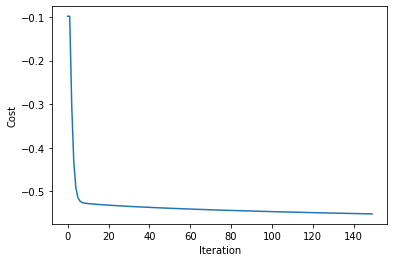

In [12]:
plt.plot(cost_vals)
plt.xlabel('Iteration')
plt.ylabel('Cost');